In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.append('/homes/dfs1/Refltools')

sys.path.append('/homes/dfs1/nist_cdsaxs/src/cdsaxs/Fitting/')
import CDSAXSFunctions as CD

from Fingerprint import loadSAXS, apply_power_law_scaling_and_plot,split_peak_data, find_peaks_by_sections,extract_peak_intensities, BCPSimFit_2DParameterSweep_Modified,analyze_xrd_data, SimInt_BCP,plot_peaks_over_data,extract_peak_data, pitchcalc_from_results, FreeFormTrapezoid,  SimIntLog_BCP, SimIntLog_BCP, BCPSimFit_V2, BCPSimFit_DWSweep, BCPSimFit_2DParameterSweep

import scipy.optimize
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import find_peaks, peak_widths


# Import and compare data

In [ ]:
SM24_Old=loadSAXS(filename='SM24Old.csv', plot_data=False)
SM24_Thin=loadSAXS(filename='SM24_Thin.csv', plot_data=False)
SM24_Thick=loadSAXS(filename='SM24_Thick.csv', plot_data=False)




Text(0, 0.5, 'Intensity a.u.')

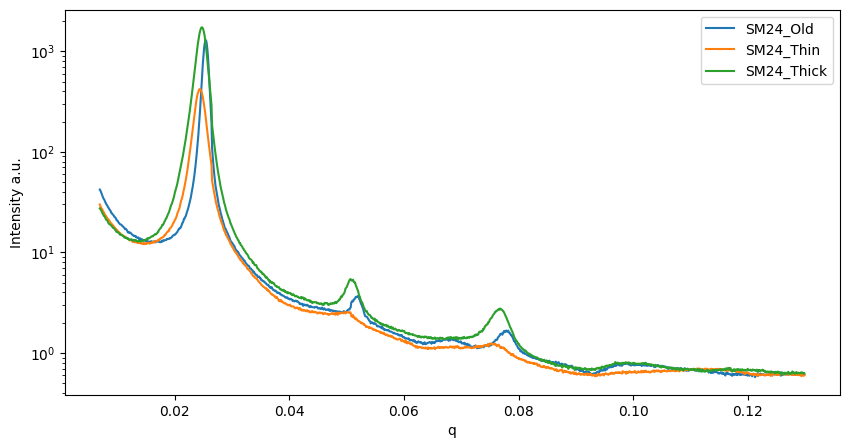

In [3]:
fig,ax=plt.subplots(1,1, figsize=(10,5))
ax.plot(SM24_Old[:,0],SM24_Old[:,1], label='SM24_Old')
ax.plot(SM24_Thin[:,0],SM24_Thin[:,1], label='SM24_Thin')
ax.plot(SM24_Thick[:,0],SM24_Thick[:,1], label='SM24_Thick')
ax.set_yscale('log')
ax.legend(loc='upper right')
ax.set_xlabel('q')
ax.set_ylabel('Intensity a.u.')

fig,ax=plt.subplots(1,1, figsize=(10,5))

## SM24 Old

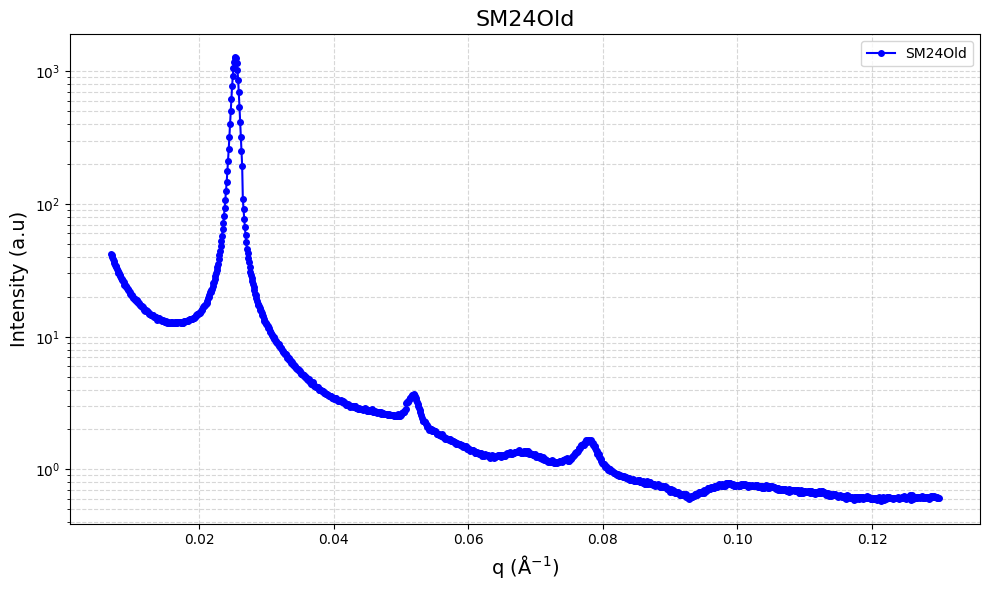

In [4]:
SM24_Old=loadSAXS(filename='SM24Old.csv', plot_data=True)



239.3594402735074


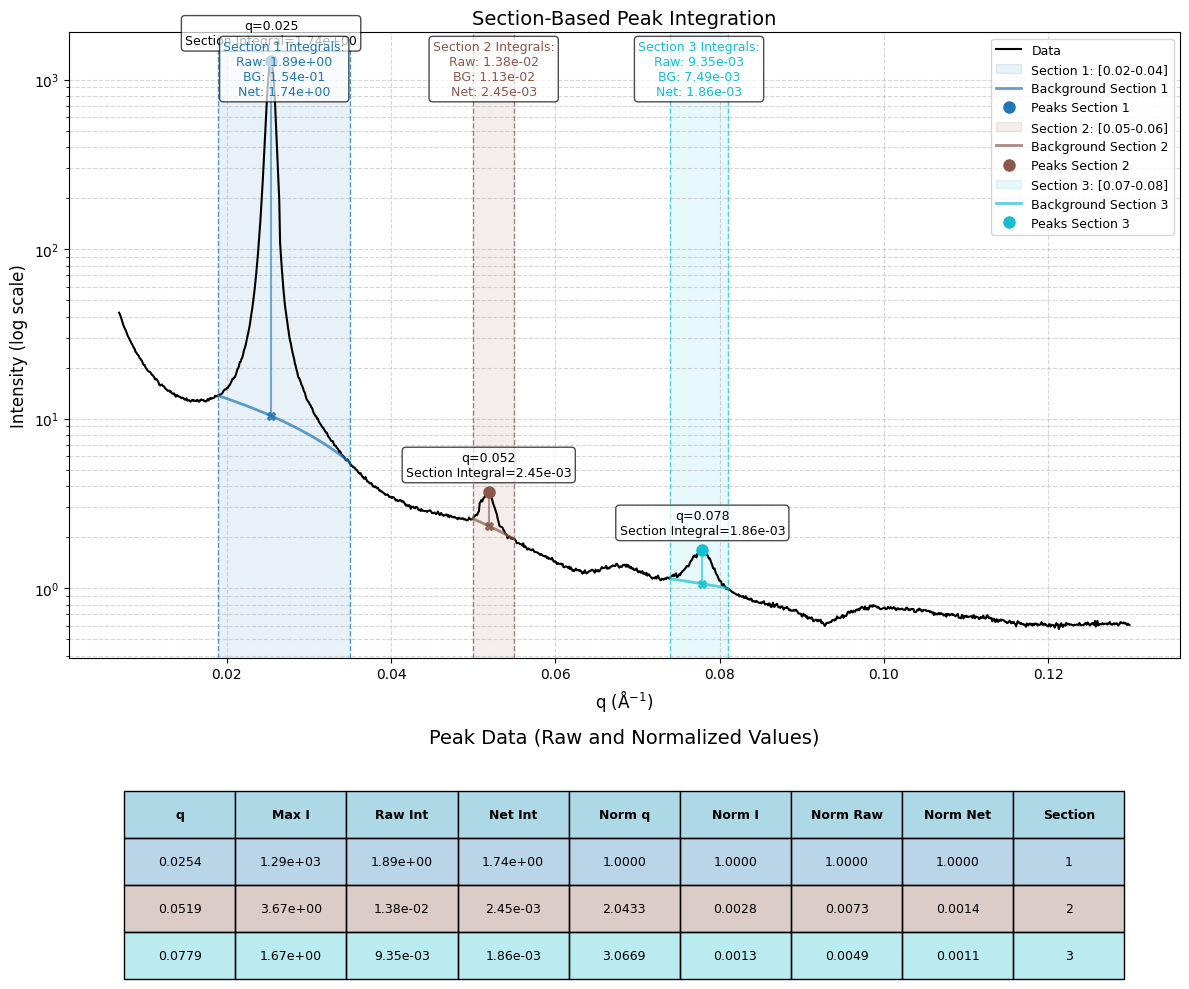

In [5]:

sections = [
    {'q_range': (0.019, 0.035),'height': 100,'width': (0.1, 50),'prominence': 10},
    {'q_range': (0.05, 0.055), 'height': 0.1,'width': (2, 50),'prominence': 0.15},
    {'q_range': (0.074, 0.081), 'height': 0.1,'width': (0.1, 50),'prominence': 0.1},
    ]
peak_results_SM24Old,plot= find_peaks_by_sections(SM24_Old, sections)
pitch_SM24Old, spacings_SM24Old = pitchcalc_from_results(peak_results_SM24Old)

print(pitch_SM24Old)

# Initialize DW Fit and view form factor
## You don't have to do this part

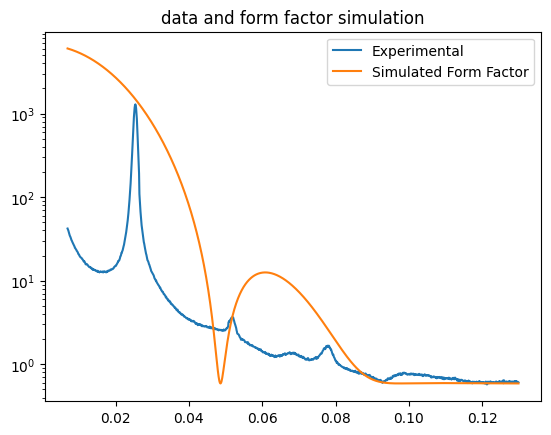

In [6]:
DW = 28 # this is in A
I0 = 0.001
Bk =0.59
Fraction=0.54

SimBCP=SimInt_BCP(SM24_Old[:,0],pitch_SM24Old,Fraction,I0,DW,Bk)

plt.plot(SM24_Old[:,0],SM24_Old[:,1], label='Experimental')

plt.plot(SM24_Old[:,0],SimBCP, label='Simulated Form Factor')
plt.title('data and form factor simulation')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

# Fit peak intensities
## This is a single optimizaiton, which has been iffy in terms of returning the best fit, the sweep below has been more reliable

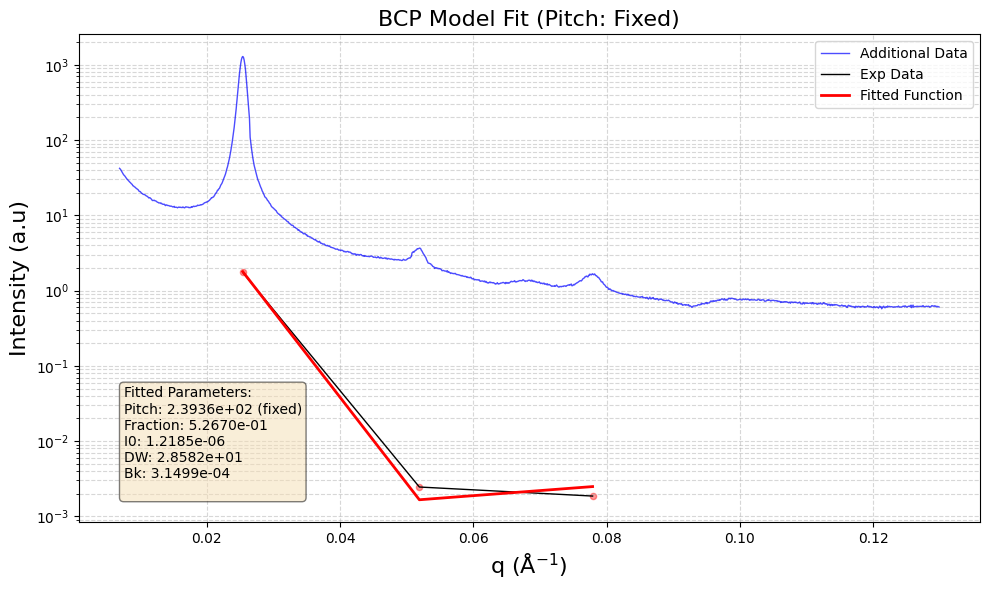

fraction 0.5267044881568319 I0 1.2184641285852957e-06 DW 28.581512657483124 DWratio 0.11940833678765317


In [9]:
DW = 30 # this is in A
I0 = 0.0001
Bk =0.0003
Fraction=0.57


params_SM24Old, params_cov_SM24Old = BCPSimFit_V2(data=peak_results_SM24Old['peaks_net'], Pitch_mean= pitch_SM24Old,Fraction=Fraction, DW=DW,I0= I0,Bk=Bk,additional_data=SM24_Old, logfit=True)
print('fraction',params_SM24Old[1],'I0',params_SM24Old[2],'DW',params_SM24Old[3], 'DWratio',params_SM24Old[3]/pitch_SM24Old,)

## Parameter sweep

Starting 2D parameter sweep with 100 combinations...
Progress: 10.0% (10 successful fits)
Progress: 20.0% (20 successful fits)
Progress: 30.0% (30 successful fits)
Progress: 40.0% (40 successful fits)
Progress: 50.0% (50 successful fits)
Progress: 60.0% (60 successful fits)
Progress: 70.0% (70 successful fits)
Progress: 80.0% (80 successful fits)
Progress: 90.0% (90 successful fits)
Progress: 100.0% (100 successful fits)

Completed 100 of 100 fits successfully.
Best fit found at Fraction = 0.5333, DW = 30.0000 with goodness of fit = 3.8525e-03
Best parameters: Pitch = 239.3594 (fixed), Fraction = 0.5333, I0 = 1.3605e-06, DW = 30.0000, Bk = 3.1500e-04


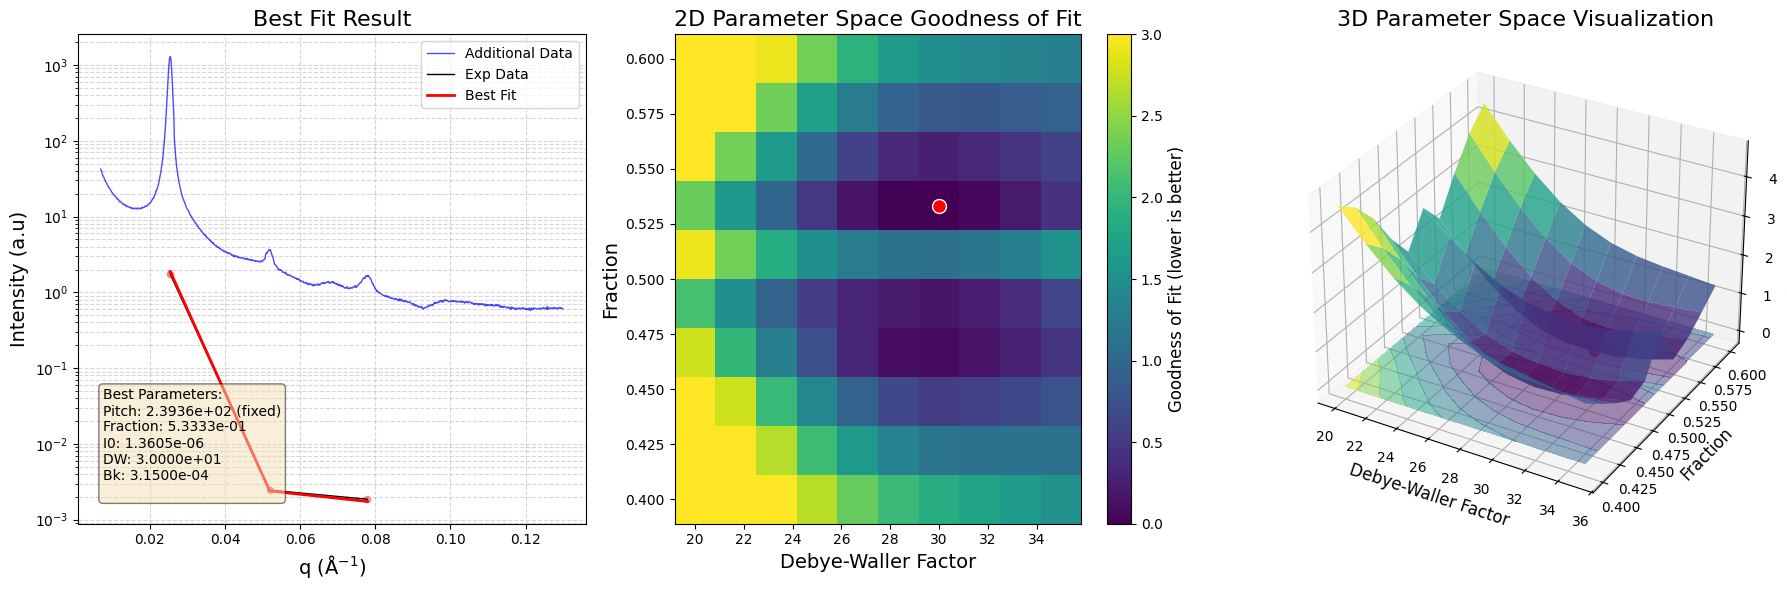

Could not create focused view: index 1 is out of bounds for axis 0 with size 1


/homes/dfs1/mambaforge/envs/CDSAXS/lib/python3.13/site-packages/matplotlib/colorbar.py:1233: RuntimeWarning: invalid value encountered in divide
  y = y / (self._boundaries[self._inside][-1] -


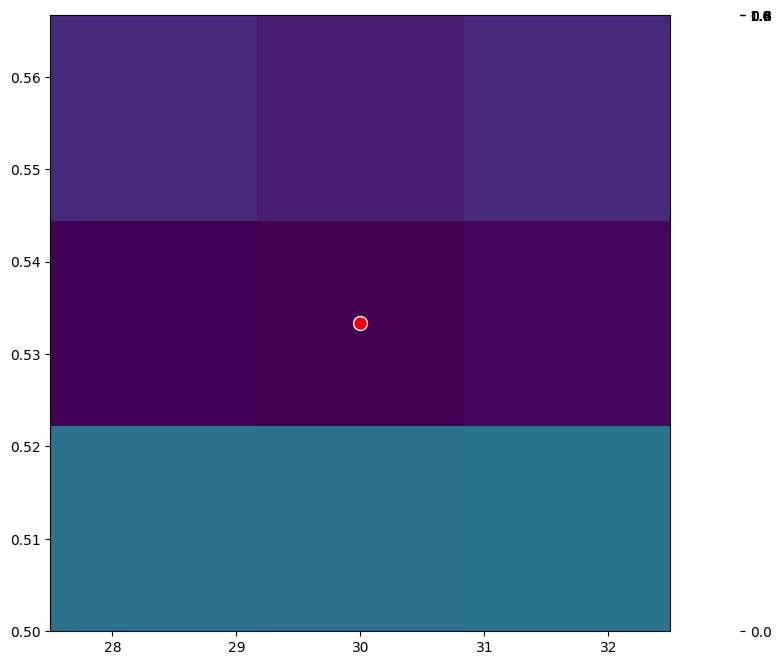

In [ ]:
best_params, best_cov, sweep_results = BCPSimFit_2DParameterSweep_Modified(
    peak_results_SM24Old['peaks_net'], 
    Pitch_mean=pitch_SM24Old, 
    Fraction_start=0.4, 
    Fraction_end=0.6, 
    Fraction_steps=100,
    DW_start=20, 
    DW_end=35, 
    DW_steps=100,
    I0=I0, 
    Bk=Bk, 
    logfit=True,
    additional_data=SM24_Old, 
    intensity_scale=(0,3)# optional
)

/homes/dfs1/Refltools/Fingerprint.py:2316: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_cov = scipy.optimize.curve_fit(


Best fit found at DW = 29.3939 with goodness of fit = 1.6150e-05 (Pitch: fixed)
Best parameters: Pitch = 239.3594 (fixed), Fraction = 0.5341, I0 = 1.2232e-06, DW = 29.3939, Bk = 2.8500e-04


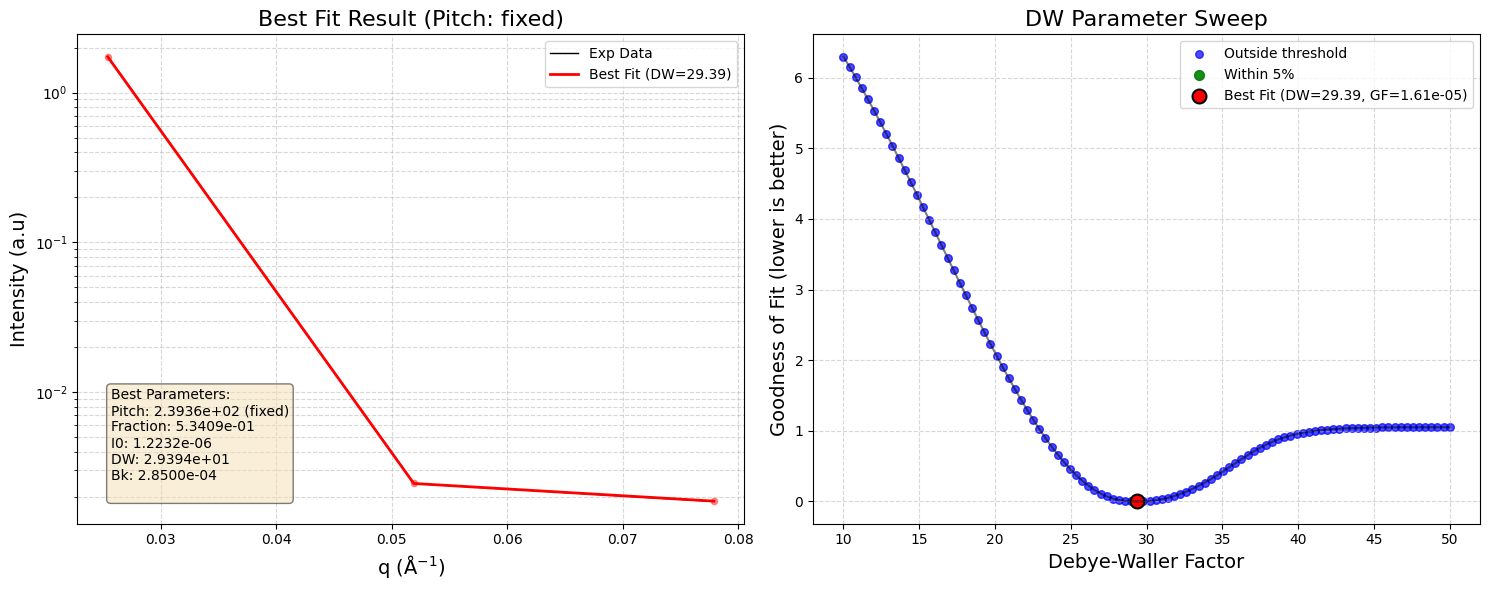

In [55]:
best_params, best_cov, dw_values, gf_values = BCPSimFit_DWSweep(
    peak_results_SM24Old['peaks_net'], Pitch_mean=pitch_SM24Old, Fraction=Fraction, 
    DW_start=10, DW_end=50, DW_steps=100,
    I0=I0, Bk=Bk, highlight_percent=5, logfit=True
)
